## Language modeling with RNN

Language models on the materials of **Sigmorphon 2018 Shared Task** for Russian dataset

In [20]:
#!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
#!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
#!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

In [1]:
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline

### Read words

In [2]:
def read_infile(infile):
    words = []
    
    with open(infile, "r") as f:
        for line in f.readlines():
            _, form, *tags = line.split()
            if len(tags) == 1:
                words.append(form)
    return words

In [3]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9213 917 922
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла идеальна гулкой


In [4]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

vocab = SimpleVocabulary(special_tokens=["<PAD>", "<BEGIN>", "<END>"], save_path = "/")
vocab.fit([list(x) for x in train_words])
print(len(vocab))

2020-03-27 19:26:00.321 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


52


In [5]:
import numpy as np
from torch.utils.data import Dataset as TorchDataset
import torch

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
       
        source =[self.vocab("<BEGIN>")]
        source.extend([self.vocab(x) for x in self.data[index]])
        
        target = source[1:].copy()
        target.append(self.vocab("<END>"))
        
        return torch.tensor(source, dtype = torch.long), torch.tensor(target, dtype = torch.long)
        

    def __len__(self):
        return len(self.data)

In [6]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=1)


for i in range(10):
    x, y = next(iter(dataloader)) 
    print(x.shape, y.shape)

torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 12]) torch.Size([1, 12])


#### *In order to create batch we need to stack(vertically) vectors, but we have vectors representing words with different lengths. In this case, it is impossible to create batch without padding shorter words*

### Collate function for padding to create batcher

In [8]:
def pad_tensor(vec, length, dim, pad_symbol):
    num_pad  = length - vec.shape[dim]
    pad = torch.fill_(torch.empty(num_pad, dtype = torch.long), pad_symbol)
    return torch.cat((vec, pad), dim=0)#.unsqueeze(0)

class Padder:
    
    def __init__(self, dim=0, pad_symbol=2):
        self.dim = dim
        self.pad_symbol = pad_symbol
        self.x_len, self.y_len = 0, 0
        
    def apply_pad(self, x, y):
        x = pad_tensor(x, self.x_len, self.dim , self.pad_symbol) 
        y = pad_tensor(y, self.y_len, self.dim , self.pad_symbol)
        return (x,y)
    
    def __call__(self, batch):
        
        for x,y in batch:
            self.x_len, self.y_len = max(self.x_len, len(x)), max(self.y_len, len(y))   
       
        
        batch = list(map(lambda x: self.apply_pad(x[0], x[1]), batch))
        
        
        xs = tuple(map(lambda x: x[0], batch))
        ys = tuple(map(lambda x: x[1], batch))
        
        xs = torch.stack(xs, dim=0)
        ys = torch.stack(ys, dim=0)
        
        return xs, ys

In [9]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset,batch_size=64, collate_fn=Padder(dim=0), shuffle=True)
val_dataloader = DataLoader(dev_dataset, batch_size=64, collate_fn=Padder(dim=0), shuffle=False)


for i in range(10):
    x, y = next(iter(dataloader)) 
    print(x.shape, y.shape)

torch.Size([64, 19]) torch.Size([64, 19])
torch.Size([64, 19]) torch.Size([64, 19])
torch.Size([64, 19]) torch.Size([64, 19])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])
torch.Size([64, 21]) torch.Size([64, 21])


## Character-based language modeling

Model description: 

1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (I am using GRU).
3. A **Linear** layer with *softmax* activation that produces the output distribution for each symbol.

In [10]:
import torch.nn as nn
from torch.nn import init

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size):
        super(RNNLM, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embeddings_dim)
        self.gru = nn.GRU(embeddings_dim, hidden_size,batch_first = True)
        self.lin = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)

        init.kaiming_normal_(self.lin.weight) 
        init.kaiming_normal_(self.emb.weight) 
        #GRU Initialization
        
    
    def forward(self, inputs, hidden=None): # [batch_size, seq_len]
        x_emb = self.emb.forward(inputs) # [batch_size,seq_len, voc_size]
        x_rnn, ht = self.gru.forward(x_emb) # [batch_size, seq_len, hi], [hidden_size, seq_len]
        x_lin = self.lin.forward(x_rnn)
        prob = self.softmax(x_lin)
        return prob, ht


In [11]:
def validate_on_batch(model, criterion, x, y):
    pred, ht = model(x)
    loss = criterion(pred.permute([0,2,1]), y)
    return loss

In [12]:
def train_on_batch(model, criterion, x, y, optimizer):
    
    loss = torch.mean(validate_on_batch(model, criterion, x, y))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_avg = loss.item()
    
    return loss_avg

### Train loop function

In [22]:
def train_eval(model, dataloader, val_dataloader, optimizer, scheduler, criterion, epochs):
    
    train_losses = []
    val_losses = []
    iter_b = dataloader.__len__()
    
    model.to(device = DEVICE)
    for e in range(1, epochs+1):
        model.train() 
    
        t_loss = 0
        for x, y in dataloader:
            x, y = x.to(device = DEVICE), y.to(device = DEVICE)
    
            loss_avgb = train_on_batch(model, criterion, x, y, optimizer) # average on batch
            t_loss += loss_avgb
    
        t_loss_avg = t_loss/iter_b # average on one epoch
        
        train_losses.append(t_loss_avg) 
        print("[{}] loss: {:.3f} ".format(e, t_loss_avg))
        
        scheduler.step()
        
        val_loss = validate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
    return val_losses

def validate(model, criterion, dataloader):
    model.eval()
    
    iter_b = dataloader.__len__()
    v_lossb_avg = 0.0
    
    with torch.no_grad():
        for (x,y) in dataloader:
            v_lossb_avg += torch.mean(validate_on_batch(model, criterion, x, y))

    return v_lossb_avg/iter_b

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
vocab_size = len(vocab)
embeddings_dim = 20
hidden_size = 30

model = RNNLM(vocab_size, embeddings_dim, hidden_size)

optimizer = optim.Adam(model.parameters(), lr = 0.03)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma = 0.01)
criterion = nn.NLLLoss(ignore_index=vocab['<PAD>'], reduction="none")

In [26]:
loss = train_eval(model, dataloader, val_dataloader, optimizer, scheduler, criterion, 5)

[1]loss: 1.020 
[2]loss: 0.869 
[3]loss: 0.845 
[4]loss: 0.838 
[5]loss: 0.836 


Text(0.5, 0, 'Epoch')

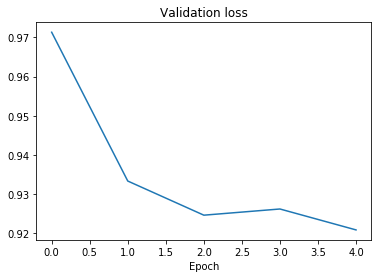

In [29]:
plt.plot(loss)
plt.title("Validation loss")
plt.xlabel("Epoch")

### Using language model to generate words

TODO:
- Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.
- Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the *DataLoader*.
- Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.
- Use generate to sample 20 pseudowords. Do not forget to transform indexes to letters.
- Write a batched version of the generation function.
- improve the perplexity of the model.

In [35]:
def predict_on_batch(model, x, vocab):
    model.eval()
    out, hidden = model(x)
    pred = torch.exp(out)
     
    return pred


### Indexing output by y true values

In [40]:
np.vectorize(lambda x: vocab[x])(x_d)

array([['<BEGIN>', 'х', 'р', ..., '<END>', '<END>', '<END>'],
       ['<BEGIN>', 'н', 'а', ..., '<END>', '<END>', '<END>'],
       ['<BEGIN>', 'р', 'а', ..., '<END>', '<END>', '<END>'],
       ...,
       ['<BEGIN>', 'м', 'у', ..., '<END>', '<END>', '<END>'],
       ['<BEGIN>', 'с', 'о', ..., '<END>', '<END>', '<END>'],
       ['<BEGIN>', 'р', 'а', ..., '<END>', '<END>', '<END>']], dtype='<U7')

In [54]:
def letter_prob(model, dataloader, vocab):
    with torch.no_grad():
        words_probs = []
        for x, _ in dataloader:
            words_probs.append(predict_on_batch(model, x, vocab))
        return words_probs

test_loader = DataLoader(test_dataset, shuffle=False)
word_probabilities = letter_prob(model, test_loader, vocab)

In [30]:
def aux_generate(model, index, last_hidden):
    x = torch.tensor(index, dtype=torch.long).reshape(1,1)
    distribution, hidden = model.forward(x,hidden = last_hidden)
    return distribution, hidden

def generate_word(model, vocab, max_length=20, start_index=1, end_index=2):
    word = ''
    
    hidden_state = None
    last_symbol = np.random.randint(3, 52)
    
    length = 0
    while(last_symbol != end_index and length <= max_length):
        word += vocab[last_symbol]
        distribution, hidden_state = aux_generate(model, last_symbol, hidden_state)
        length += 1
        last_symbol = int(torch.multinomial(torch.exp(distribution), 1))
        
    return word

def generate(model, max_length=20, start_index=1, end_index=2):
    return generate_word(model, vocab, max_length=20, start_index=1, end_index=2)

In [ ]:
generate_word(model, vocab)

In [ ]:
def generate_batch(model, batch_size, max_length = 20, start_index=1, end_index=2):
    pass

In [ ]:
# ADD PERPLEXITY ON VALIDATION
# DROPOut

In [ ]:
# QUESTION
# - Why not hot-encoded
# - 